# Au epitaxy on MoS2 with GMSH-FEniCS workflow 
Author: Joel W. Ager (jwager@lbl.gov), [Group website](http://ager.mse.berkeley.edu), [github](https://github.com/joelager)

**Goal**  
Using mesh generated with `GMSH` and FEM calucations done with `FEniCS`, use the awkward `GMSH`-`FEAP` workflow to explore different geometries

**Status**  
Works - only issue is the magnitude of the thermal expansion mismatch strain. It is larger than expected but can be adjusted to match FEAP and COMSOL. 

# Import

In [1]:
from fenics import *                     
# from dolfin import *               # This has the same classes as fenics 

import matplotlib.pyplot as plt
import numpy as np

import meshio                      # Needed for importing meshes

# Materials and mesh parameters

In [6]:
# Geometry - still manual
a = 150.0;        # Width
b = 150.0;       # Heigth
#L = 60;          # Height of islande

# Units
GPa = 1e9        # SI

#For MoS2 Poisson’s ratio of 0.25, and Young’s modulus of 270 GPa
# I will modify islands by using the exponent, 10 for 10x, 11 for 100x

E_MoS2 = 270*GPa
ν = 0.25 
α_MoS2 = 0

Au_MoS2_factor = 100.           # Eric used 100
E_AuMoS2 = E_MoS2*Au_MoS2_factor
α_AuMoS2 = 1e-4                # So delta_T = -100 for -1% compression


# Lame parameters for MoS2, for both plane strain or plane stress case
λ_MoS2 = E_MoS2*ν/((1 + ν)*(1 - 2*ν))          # 1st Lame parameter, plane strain form
λ_MoS2_hat = E_MoS2*ν/(1 - ν**2)               # 1st Lame parameter, *plane stress form*
μ_MoS2 = E_MoS2/(2*(1 + ν))                    # 2nd Lame parameter, equal to shear modulus

# Lame parameters for Au-MoS2, check to see plane strain or plane stress case
λ_AuMoS2 = E_AuMoS2*ν/((1 + ν)*(1 - 2*ν))      # 1st Lame parameter, plane strain form
λ_AuMoS2_hat = E_AuMoS2*ν/(1 - ν**2)           # 1st Lame parameter, *plane stress form*
μ_AuMoS2 = E_AuMoS2/(2*(1 + ν))               # 2nd Lame parameter, equal to shear modulus



# Import mesh

Worked without any problems!

Imported 9802 elements
Got data from 9802 elements


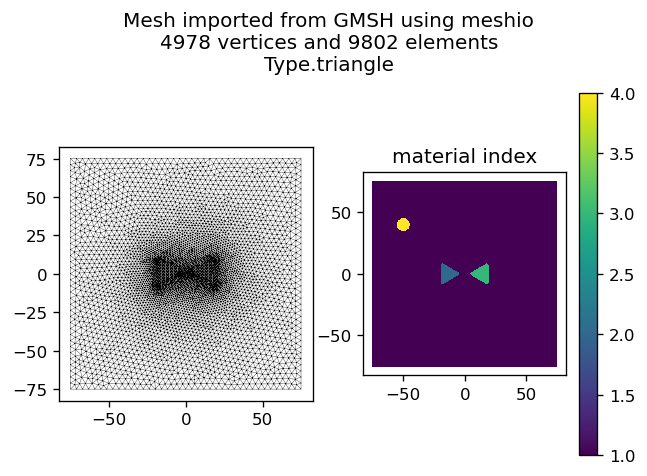

In [7]:
mesh = Mesh()
with XDMFFile("Islands on MoS2.xdmf") as infile:
    infile.read(mesh)
print('Imported {} elements'.format(mesh.num_cells()))

# Now get stored values, mvc means "mesh value collection"
mvc = MeshValueCollection("size_t", mesh, 2) 
with XDMFFile("Islands on MoS2.xdmf") as infile:
    infile.read(mvc, "gmsh:physical")                # found this tag in the XML file
material_index = cpp.mesh.MeshFunctionSizet(mesh, mvc)

print('Got data from {} elements'.format(mvc.size()))

plt.figure(dpi=120)
plt.suptitle('Mesh imported from GMSH using meshio\n'
         '{} vertices and {} elements\n'
         '{}'.format(mesh.num_vertices(),mesh.num_cells(), mesh.type().cell_type()),y=1.05)
plt.subplot(1,2,1)
plot(mesh, color="k", linewidth=0.2, zorder=0)
plt.subplot(1,2,2)
plt.title('material index')
c=plot(material_index)
plt.colorbar(c)
plt.show()

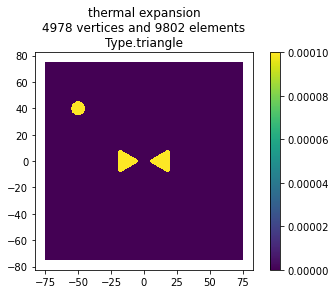

In [8]:
# Now make the function spaces for the Young's modulus, Poisson ratio, and thermal expansion coefficient
# DG is discontinuous Galerkin
# Order 0 as there are discontinuities
V_mat_param = FunctionSpace(mesh, 'DG', 0)           

# Now make functions for the parameters on that space
lambda_Lame =  Function(V_mat_param)            # lambda is reserved
mu_Lame = Function(V_mat_param)
alpha = Function(V_mat_param)

# To assign parameters, simply iterate over all elements
#  note the cast to int for the comparison
for cell_num in range(mesh.num_cells()):
    if int(material_index.array()[cell_num])==1:
        lambda_Lame.vector()[cell_num] = λ_MoS2_hat
        mu_Lame.vector()[cell_num] = μ_MoS2
        alpha.vector()[cell_num] = α_MoS2
    else:
        lambda_Lame.vector()[cell_num] = λ_AuMoS2_hat
        mu_Lame.vector()[cell_num] = μ_AuMoS2
        alpha.vector()[cell_num] = α_AuMoS2

# Check to make sure set correctly
plt.title('thermal expansion\n'
         '{} vertices and {} elements\n'
         '{}'.format(mesh.num_vertices(),mesh.num_cells(), mesh.type().cell_type()))
c=plot(alpha)
plt.colorbar(c)
plt.show()

# Set up and solve linear thermoelastic problem

T is set as a constant using a `FEniCS` function  
One also needs to specify functions to compute strain and stress from the displacement

In [9]:
# Set the strain
delta_T = Constant(-170.0)           # Adjusted to get -2% strain in the islands

f = Constant((0, 0))                 # No body forces

# Calculates strain from displacement vector, returns a tensor
def eps(u):
    return sym(grad(u))

# Calculates stress from displacement and temperature, returns a tensor
# Includes the thermal expansion term
def sigma(u, dT):
    return (lambda_Lame*tr(eps(u))- alpha*(3*lambda_Lame+2*mu_Lame)*dT)*Identity(2) + 2.0*mu_Lame*eps(u)

# Function for space and trial and test functions
Vu = VectorFunctionSpace(mesh, 'CG', 2)    # Continuous Galerkin, same as saying "Lagrande"
u_trial = TrialFunction(Vu)                
u_test = TestFunction(Vu)                  

# Making the weak form
# delta_T is a constant set above
Wint = inner(sigma(u_trial, delta_T), eps(u_test))*dx
aM = lhs(Wint)
LM = rhs(Wint) + inner(f, u_test)*dx             # f is here, will be zero in the first solution

# Dirichlet BCs at all boundaries, x and y displacements are zero
def bottom(x, on_boundary):
    return near(x[1], -b/2) and on_boundary
def top(x, on_boundary):
    return near(x[1], +b/2) and on_boundary
def left(x, on_boundary):
    return near(x[0], -a/2) and on_boundary
def right(x, on_boundary):
    return near(x[0], +a/2) and on_boundary

#  in FEAP I just fixed y at the bottom. Here both DOFs are fixed
bc_bottom = DirichletBC(Vu, Constant((0., 0.)), bottom)
bc_top = DirichletBC(Vu, Constant((0., 0.)), top)
bc_left = DirichletBC(Vu, Constant((0., 0.)), left)
bc_right = DirichletBC(Vu, Constant((0., 0.)), right)
bcs = [bc_bottom, bc_top, bc_left, bc_right]

# Function for the solution
u = Function(Vu, name="Displacement")

solve(aM == LM, u, bcs)

# For 2D visualization
stress_tensor = sigma(u, delta_T)
strain_tensor = eps(u)

# For making slices through solution
# Need to make a new *tensor* space to hold results (Took forever to figure this out)
V_tensor = TensorFunctionSpace(mesh, "DG", 1)      # 0 degree was not smooth, 1 and 2 seem similar
epsilon_sol = Function(V_tensor, name="Strain")
sigma_sol = Function(V_tensor, name="Stress")

# These are similar to interpolation functions
epsilon_sol.assign(project(eps(u), V_tensor))
sigma_sol.assign(project(sigma(u, delta_T), V_tensor))

print("Strain at (0,0):", epsilon_sol(0, 0))

Strain at (0,0): [ 0.02973164 -0.00023012 -0.00023012 -0.01942757]


At this point one has the displacements at the elements.  
> Can interpolate displacement u 

To be able to graph slice of strain and stress, you need to project onto a tensor space.
> You need to make a new tensor space and use the functions for strain (depends on u) and stress (depends on u and delta_T)
> the location should be the lattice before it is displaced 

# Post-processsing

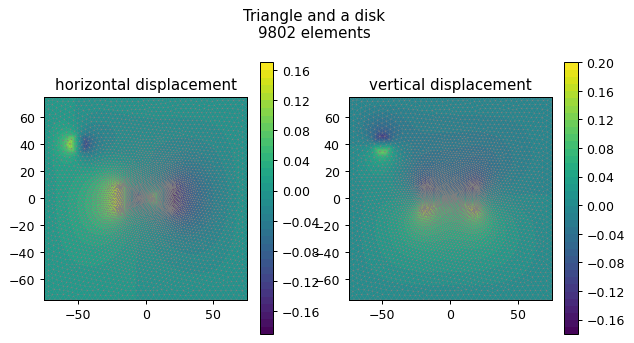

In [11]:
fig = plt.figure(figsize=(8,4), dpi=90)
fig.suptitle('Triangle and a disk\n'
            '{} elements\n'.format(mesh.num_cells()), y=1.03)
plt.subplot(1,2,1)
p = plot(u[0],title="horizontal displacement")
plot(mesh, linewidth=0.2, zorder=1)
plt.colorbar(p)
plt.subplot(1,2,2)
p = plot(u[1],title="vertical displacement")
plot(mesh, linewidth=0.2, zorder=1)
plt.colorbar(p)
plt.show()

In [7]:
# OMG it appears to be working. So now need to figure out how to get stress and strain. 

In [8]:
%%capture
help(plot)

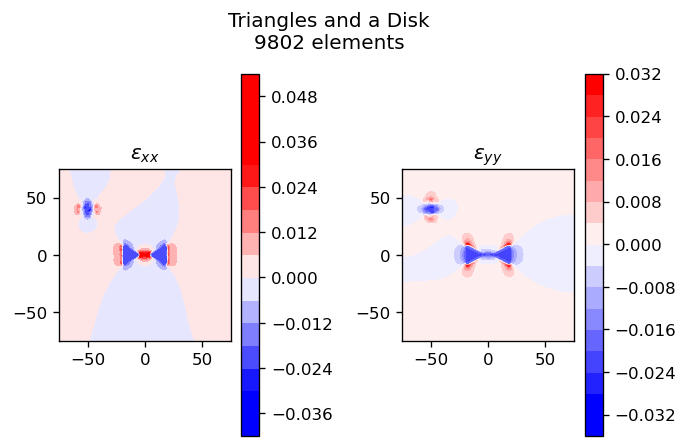

In [12]:
fig = plt.figure(dpi=120)
fig.suptitle('Triangles and a Disk\n'
            '{} elements\n'.format(mesh.num_cells()), y=1.01)
plt.subplot(1,2,1)
plt.title('$\epsilon_{xx}$')
c=plot(strain_tensor[0, 0], levels=16)
c.set_cmap("bwr")
c.set_clim(-0.03, 0.03)
plt.colorbar(c)
plt.subplot(1,2,2)
plt.title('$\epsilon_{yy}$')
p=plot(strain_tensor[1, 1], levels=16)
p.set_cmap("bwr")
p.set_clim(-0.03, 0.03)
plt.colorbar(p)
plt.subplots_adjust(wspace=0.6)
plt.show()

NameError: name 'L' is not defined

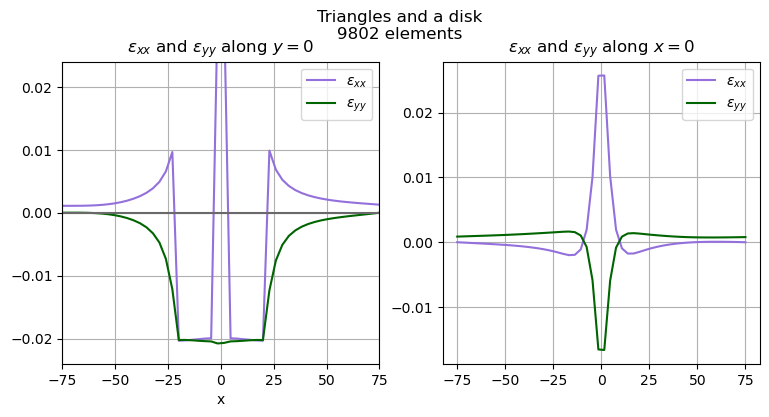

In [14]:
# Finally can plot
x_plot = np.linspace(-a/2, a/2, 50)
y_plot = np.linspace(-b/2, b/2, 50)


fig, (ax1,ax2) = plt.subplots(1,2, dpi=100, figsize=(9,4), sharex=False)
fig.suptitle('Triangles and a disk\n'
            '{} elements\n'.format(mesh.num_cells()), y=1.01)

ax1.set_title('$\epsilon_{xx}$ and $\epsilon_{yy}$ along $y=0$')

ax1.plot(x_plot, [epsilon_sol(x, 0)[0] for x in x_plot], 
         'mediumpurple', label='$\epsilon_{xx}$')
ax1.plot(x_plot, [epsilon_sol(x, 0)[3] for x in x_plot], 
         'darkgreen', label='$\epsilon_{yy}$')
ax1.grid()
ax1.legend()
#ax1.axvspan(-G/2-W, -G/2, alpha=0.45, color='gainsboro')
#ax1.axvspan(G/2, G/2+W, alpha=0.45, color='gainsboro')
ax1.axhline(y=0, color='dimgrey')
ax1.set_xlim(-a/2,a/2)
ax1.set_ylim(-0.024, 0.024)
ax1.set_xlabel('x')

ax2.set_title('$\epsilon_{xx}$ and $\epsilon_{yy}$ along $x=0$')
ax2.plot(y_plot, [epsilon_sol(0, y)[0] for y in y_plot], 
         'mediumpurple', label='$\epsilon_{xx}$')
ax2.plot(y_plot, [epsilon_sol(0, y)[3] for y in y_plot], 
         'darkgreen', label='$\epsilon_{yy}$')
ax2.grid()
ax2.legend()
ax2.axvspan(-L/2, L/2, alpha=0.45, color='gainsboro')
ax2.axhline(y=0, color='dimgrey')
ax2.set_xlim(-b/2,b/2)
ax2.set_ylim(-0.024, 0.024)

ax2.set_xlabel('y')
plt.show()

*Agreement with Eric's paper is excellent (and better than with FEAP due to the finer, unstructured, mesh)*

# Export data  
`xdmf` is now the recommended format. In order to save multiple things, have to use a (fake) time step. The mesh and the scalar/vector/tensor output is put in an `h5` file (binary) with an index to it in the `xdmf` file.

Tensor fields (I think):
```
0   xx  
1   xy  
2   xz - zero for this data set  
3   xy  
4   yy  
5   yz - zero    
6   xz - zero   
7   yz - zero  
8   zz - zero   
```
For 2D only 4 are non zero. 




In [15]:
with XDMFFile('Triangles and a disk') as xdmf:
    xdmf.write(mesh)
    xdmf.write(u, 0)               # Second argument is time step
    xdmf.write(epsilon_sol, 1)
    xdmf.write(sigma_sol, 2)